In [1]:
import itertools
import pathlib

import jsonlines
import pandas as pd
import seaborn as sns
import torch

from tqdm import tqdm


from yoshimidi.data.midi_dataset import MidiDataset
from yoshimidi.data.parse import one_hot_parsing, time_parsing
from yoshimidi.output_config import OutputConfig
from yoshimidi.train import checkpoints, midi_activation
from yoshimidi.train.transformer import Transformer
from yoshimidi.train.transformer_config import TransformerConfig

In [2]:
CTX = 1024
dataset = MidiDataset.from_path(
    path=pathlib.Path("../out/dataset/03_tokenized"),
    context_window=CTX,
    device=torch.device("cpu"),
    dtype=torch.float32,
)

In [4]:
batch = dataset[0]
start, end = one_hot_parsing.piece_range("time")
print(start, end, batch.shape)
print(batch[:, start:end])

26 42 torch.Size([1024, 42])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [5]:
dataset_time_uint8s = []
dataset_times = []
for batch_idx in tqdm(range(100)):
    batch = dataset[batch_idx]
    for i in range(CTX):
        time_uint8 = time_parsing.time_uint8_from_support(batch[i, start:end])
        time = time_parsing.time_from_uint8(time_uint8)
        dataset_time_uint8s.append(time_uint8)
        dataset_times.append(time)

100%|██████████| 100/100 [00:01<00:00, 56.21it/s]


In [6]:
parsed_times = []
with jsonlines.open("../out/dataset/02_parsed.jsonl") as f:
    for line in itertools.islice(f, 1000):
        for track in line:
            for channel in track["channels"].values():
                for note in channel["notes"]:
                    parsed_times.append(note["time_delta_secs"])

In [3]:
model = Transformer(
    TransformerConfig(
        num_layers=6,
        residual_stream_size=512,
        num_attention_heads=16,
        context_window=1024,
    )
)
optimizer = torch.optim.Adam(model.parameters())
model, optimizer = checkpoints.load_checkpoint(
    "2023-08-01_v2_moresups_untiedembs",
    step="latest",
    model=model,
    optimizer=optimizer,
    output_config=OutputConfig(checkpoints="../out/checkpoints"),
    device=torch.device("cpu"),
)
model.eval()

2023-08-02 10:20:59.651 | INFO     | yoshimidi.train.checkpoints:load_checkpoint:48 - Loading checkpoint: ../out/checkpoints/2023-08-01_v2_moresups_untiedembs/step_020500.pt


Transformer(
  (positional_encoding): _PositionalEncoding()
  (block_0): _TransformerBlock(
    (attention): _MultiHeadAttention(
      (qkv_projection): Linear(in_features=512, out_features=1536, bias=True)
      (output_layer): Linear(in_features=512, out_features=512, bias=True)
    )
    (mlp): _Mlp(
      (linear_1): Linear(in_features=512, out_features=2048, bias=True)
      (linear_2): Linear(in_features=2048, out_features=512, bias=True)
    )
    (layer_norm_attention): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layer_norm_mlp): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (block_1): _TransformerBlock(
    (attention): _MultiHeadAttention(
      (qkv_projection): Linear(in_features=512, out_features=1536, bias=True)
      (output_layer): Linear(in_features=512, out_features=512, bias=True)
    )
    (mlp): _Mlp(
      (linear_1): Linear(in_features=512, out_features=2048, bias=True)
      (linear_2): Linear(in_features=2048, out_features=512, bia

In [8]:
model_times = []
start, end = one_hot_parsing.piece_range("time")
for batch_idx in tqdm(range(100)):
    inputs = dataset[batch_idx].unsqueeze(0)
    outputs = model(inputs)
    outputs = midi_activation.midi_activation(outputs)
    for i in range(CTX):
        # time_uint8 = time_parsing.time_uint8_from_support(inputs[0, i, start:end])
        # time = time_parsing.time_from_uint8(time_uint8)
        # print(time_uint8, time)
        time_uint8 = time_parsing.time_uint8_from_support(outputs[0, i, start:end])
        time = time_parsing.time_from_uint8(time_uint8)
        # print(time_uint8, time)
        model_times.append(time)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


<Axes: xlabel='time', ylabel='Proportion'>

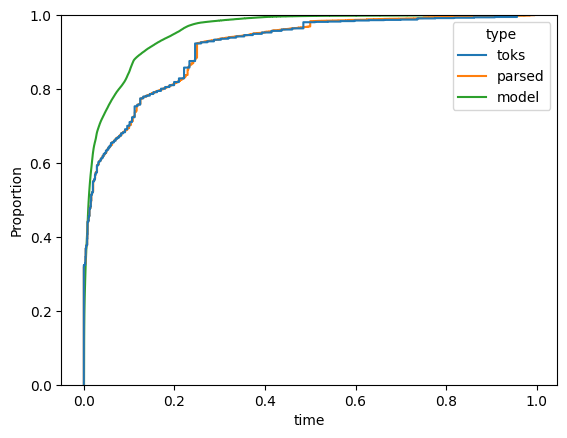

In [9]:
df = pd.DataFrame([
    *[
        dict(type="toks", time=t)
        for t in dataset_times
    ],
    *[
        dict(type="parsed", time=t)
        for t in parsed_times[:len(dataset_times)]
    ],
    *[
        dict(type="model", time=t)
        for t in model_times[:len(dataset_times)]
    ],
])
df = df[df.time < 1]
sns.ecdfplot(data=df, x="time", hue="type")

<Axes: xlabel='diff', ylabel='Proportion'>

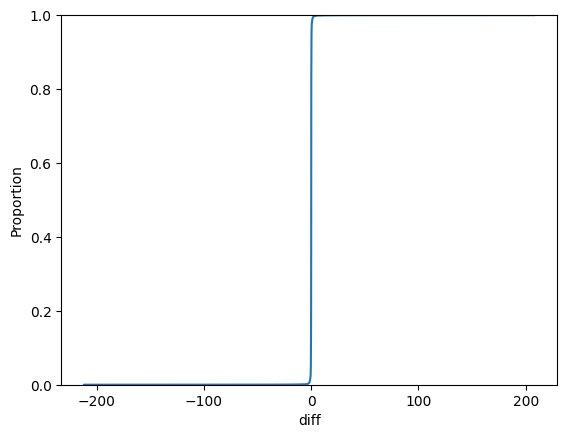

In [10]:
df = pd.DataFrame([
    dict(toks=toks, parsed=parsed, diff=toks - parsed)
    for toks, parsed in zip(dataset_times, parsed_times)
])
sns.ecdfplot(df["diff"])

In [34]:
start, end = one_hot_parsing.piece_range("time")
input_supports = []
input_time_uint8s = []
input_times = []
output_supports = []
output_time_uint8s = []
output_times = []
with torch.inference_mode():
    for batch_idx in tqdm(range(100)):
        batch = dataset[batch_idx]
        outputs = model(batch.unsqueeze(0))
        outputs[:, :, start] *= 0.95
        outputs = midi_activation.midi_activation(outputs)
        outputs = outputs[0]
        input_support = batch[:, start:end]
        output_support = outputs[:, start:end]
        input_supports.append(input_support)
        output_supports.append(output_support)


        for i in range(CTX):
            input_time_uint8 = time_parsing.time_uint8_from_support(input_support[i])
            input_time = time_parsing.time_from_uint8(input_time_uint8)
            input_time_uint8s.append(input_time_uint8)
            input_times.append(input_time)
            output_time_uint8 = time_parsing.time_uint8_from_support(output_support[i])
            output_time = time_parsing.time_from_uint8(output_time_uint8)
            output_time_uint8s.append(output_time_uint8)
            output_times.append(output_time)


100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


torch.Size([2, 102400, 16])
tensor([[3.1862e-01, 3.0864e-05, 1.3009e-03, 2.7257e-02, 4.9349e-02, 7.4841e-02,
         8.4498e-02, 5.9945e-02, 5.6628e-02, 1.0339e-01, 1.2163e-01, 6.0983e-02,
         2.3058e-02, 1.1296e-02, 6.4761e-03, 6.9210e-04],
        [2.8818e-01, 3.6571e-04, 2.4530e-03, 2.5621e-02, 6.7107e-02, 7.4834e-02,
         9.8514e-02, 6.6688e-02, 7.2903e-02, 9.8825e-02, 1.0886e-01, 6.6475e-02,
         1.6764e-02, 6.9485e-03, 4.8889e-03, 5.6952e-04]])


tensor(2.6904)

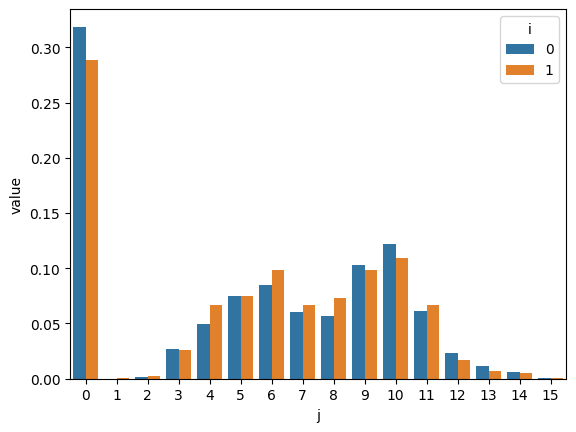

In [35]:
inputs = torch.concat(input_supports)
outputs = torch.concat(output_supports)
t = torch.stack([inputs, outputs])
print(t.shape)
print(t.mean(dim=1))
df = pd.DataFrame([
    dict(i=i, j=j, value=column.item())
    for i, row in enumerate(t.mean(dim=1))
    for j, column in enumerate(row)
])
sns.barplot(data=df, x="j", y="value", hue="i")

torch.nn.functional.cross_entropy(
    inputs, outputs
)

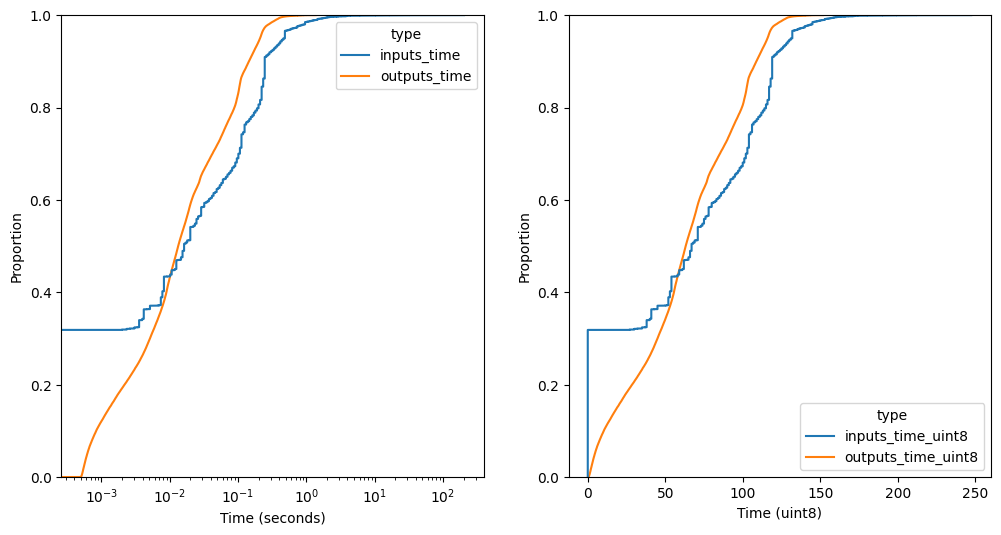

In [36]:
from matplotlib import pyplot as plt

df_time = pd.DataFrame(
    [
        *[dict(type="inputs", time=time) for time in input_times],
        *[dict(type="outputs", time=time) for time in output_times],
    ]
)
df_time = df_time.melt(id_vars=["type"], value_vars=["time"], var_name="time_type", value_name="time_value")
df_time["type"] = df_time.apply(lambda x: f"{x['type']}_{x['time_type']}", axis=1)

df_time_uint8 = pd.DataFrame(
    [
        *[dict(type="inputs", time_uint8=time_uint8) for time_uint8 in input_time_uint8s],
        *[dict(type="outputs", time_uint8=time_uint8) for time_uint8 in output_time_uint8s],
    ]
)
df_time_uint8 = df_time_uint8.melt(
    id_vars=["type"], value_vars=["time_uint8"], var_name="time_type", value_name="time_value"
)
df_time_uint8["type"] = df_time_uint8.apply(lambda x: f"{x['type']}_{x['time_type']}", axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.ecdfplot(data=df_time, x="time_value", hue="type", ax=ax1)
sns.ecdfplot(data=df_time_uint8, x="time_value", hue="type", ax=ax2)
ax1.set_xlabel("Time (seconds)")
ax2.set_xlabel("Time (uint8)")
ax1.set_xscale("log")

<Axes: xlabel='time', ylabel='Proportion'>

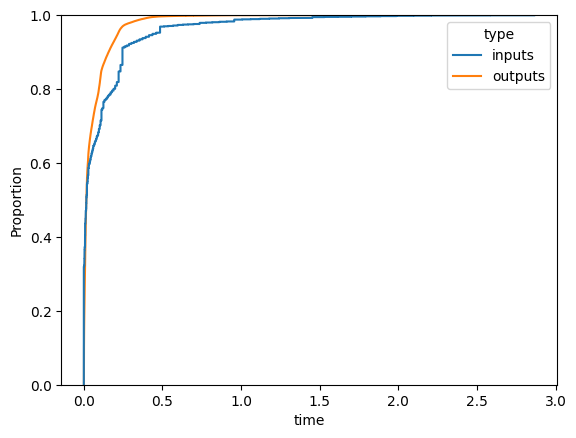

In [16]:
df = pd.DataFrame([
    *[
        dict(type="inputs", time=t)
        for t in input_times
    ],
    *[
        dict(type="outputs", time=t)
        for t in output_times
    ],
])
df = df[df.time < 3]
sns.ecdfplot(data=df, x="time", hue="type")

<Axes: xlabel='seq_idx', ylabel='time'>

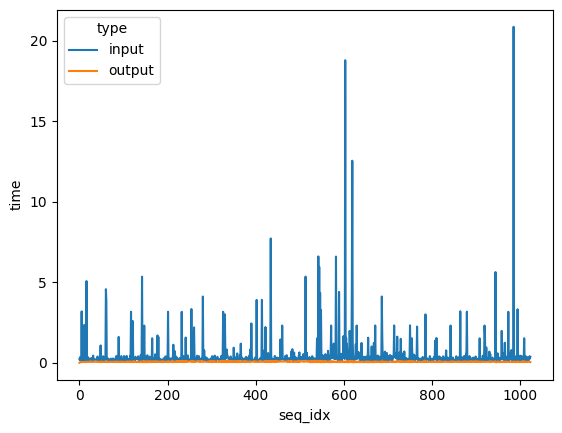

In [12]:
df = []
for type, tensor in [("input", input_supports), ("output", output_supports)]:
    for row in torch.stack(tensor):
        for seq_idx, seq in enumerate(row):
            time_uint8 = time_parsing.time_uint8_from_support(seq)
            time = time_parsing.time_from_uint8(time_uint8)
            df.append(dict(type=type, seq_idx=seq_idx, time=time))
df = pd.DataFrame(df)
# sns.barplot(data=df, x="time", y="seq_idx")
sns.lineplot(data=df.groupby(["seq_idx", "type"]).time.std().reset_index(), y="time", x="seq_idx", hue="type")

In [ ]:
for t in [0, 1, 2, 3, 4, 5]:
    time_uint8 = time_parsing.time_to_uint8(t)
    result = torch.zeros(8)
    time_parsing.time_uint8_to_support(time_uint8, result)
    print(t, result)

0 tensor([1., 0., 0., 0., 0., 0., 0., 0.])
1 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6296, 0.3704, 0.0000])
2 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1111, 0.8889, 0.0000])
3 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9570, 0.0430])
4 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8925, 0.1075])
5 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8495, 0.1505])


: 

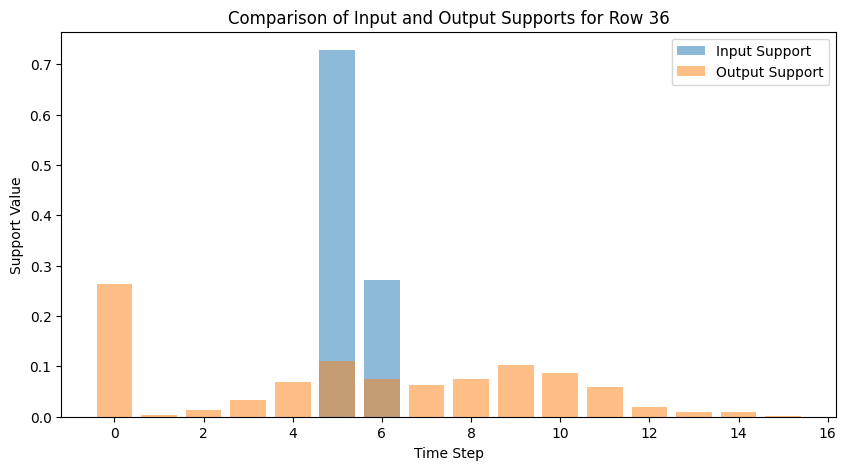

In [75]:
import matplotlib.pyplot as plt

# Select a row to compare
row_idx = 36

# Get the input and output supports for the selected row
input_support = input_supports[row_idx][0]
output_support = output_supports[row_idx][0]

# Create a bar plot to compare the input and output supports
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(input_support)), input_support, alpha=0.5, label='Input Support')
ax.bar(range(len(output_support)), output_support, alpha=0.5, label='Output Support')
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('Support Value')
ax.set_title(f'Comparison of Input and Output Supports for Row {row_idx}')
plt.show()
